# Task 5: Traffic sign classification/Recognition system

## Problem Statement : Implement a real time traffic sign classifier which identifies the traffic sign and gives an alert.
- Maintained by : **Ajinkya Jadhav**

### Reference :
- Big thanks to **Adrian Rosebrock** explaining how to implement computer vision model practically. 🙏🙏
- I have learned to implement this CV model from his tutorial.

### Import required libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os, random, glob, cv2
import datetime, seaborn as sns
from skimage import transform, io, exposure
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , BatchNormalization, MaxPool2D, Activation
from tensorflow.keras.layers import Flatten, Dropout, Dense, MaxPooling2D
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from kerastuner import HyperModel

import warnings
warnings.filterwarnings('ignore')

## Data Reading and Preprocessing

In [2]:
csv_filepath = '../input/gtsrb-german-traffic-sign/Train.csv'
trafficsign_data = pd.read_csv(csv_filepath)
trafficsign_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


**Each image have differrent width and height.**

In [3]:
# shape of the data
trafficsign_data.shape

(39209, 8)

There are **39209** images. 

In [4]:
# check for unique ClassId
trafficsign_data['ClassId'].unique()

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

There are total of 43 `ClassId` present in the data.

Let's check the count of each `ClassId`.

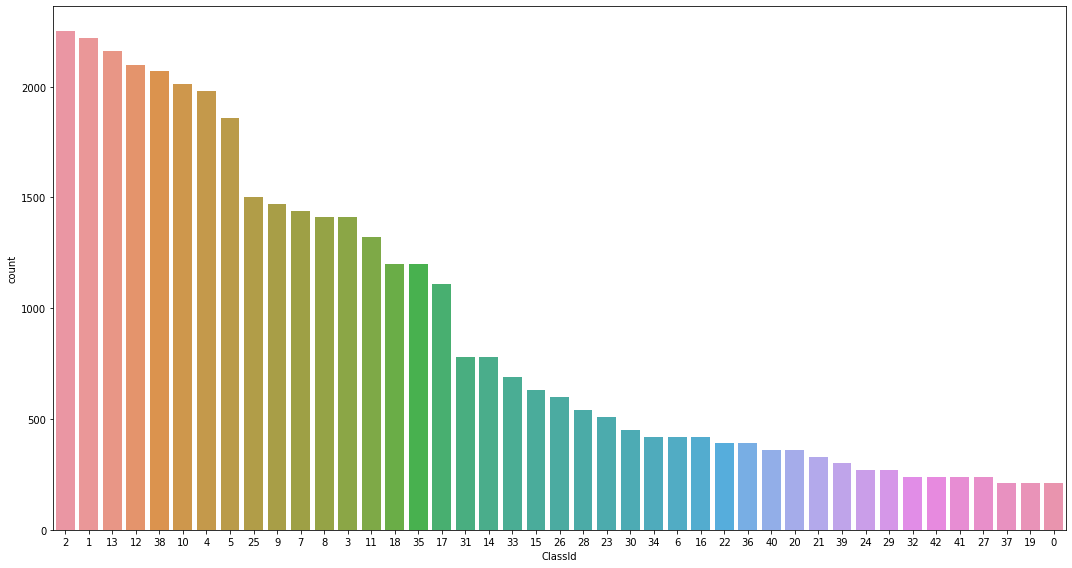

In [5]:
plt.figure(figsize=(15,8))
sns.countplot(trafficsign_data['ClassId'], order = trafficsign_data['ClassId'].value_counts().index)
plt.tight_layout()

As we can see `ClassId`s distribution is not balanced. `ClassID` 2 have most occurence in the data aprox. 2700 while `ClassId`0 have less than 500.

In [6]:
# function to load the images 
def load_images_from_folder(folder_path): 
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append(img)
    return images

In [7]:
images =load_images_from_folder("../input/gtsrb-german-traffic-sign/Test")

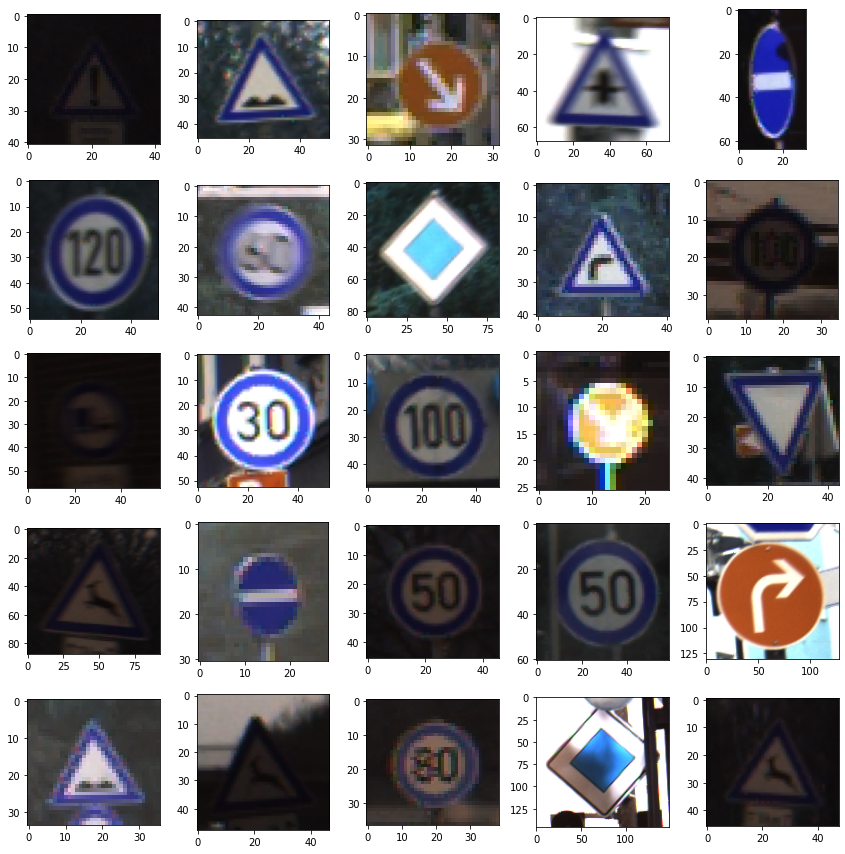

In [8]:
# displaying images
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    x = images[i]
    plt.tight_layout()
    plt.imshow(x)

As we can see that-
- Images are of low resolution and pixelated.
- Having poor lighting and contrast.
- So, need some image preprocessing.

As we know that we can not improve the image resolution but we can work on contrast level.  
- So to imrove the contrast of the image we can use **CLHAE** stands for `Contrast Limited Adaptive Histogram Equalization`. 
- It is an algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.

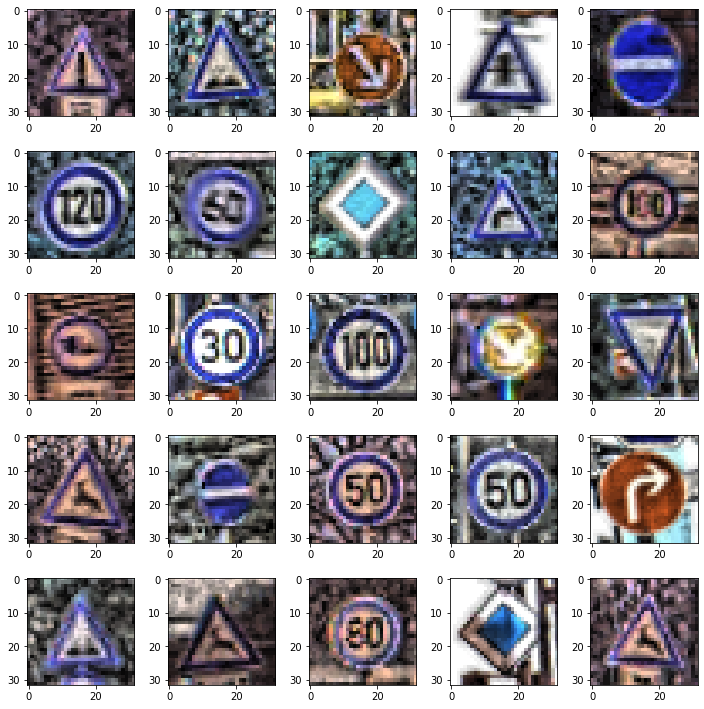

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    x = images[i]
    
    # uniform size
    x =transform.resize(x, (32,32))
    
    # CLHAE
    x = exposure.equalize_adapthist(x,clip_limit=0.1)
    plt.tight_layout()
    plt.imshow(x)

Althogh images are looking unnatural to the human eye. But we can see changes in the contrast level. In comparison to the above images they look far better. It will help machine to understand it in a better way.

In [10]:
base_path = "../input/gtsrb-german-traffic-sign"
train_csv = "../input/gtsrb-german-traffic-sign/Train.csv"
test_csv = "../input/gtsrb-german-traffic-sign/Test.csv"

In [11]:
classes = 43
height = 32
width = 32
depth = 3


# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 20
INIT_LR = 0.001
BS = 32

In [12]:
# function to load data

def load_data(basepath, csvpath):
    
    # initialize list of data and labels
    data = []
    labels = []
    
    # skipping header
    rows = open(csvpath).read().strip().split("\n")[1:]
    random.shuffle(rows)
    
    #looping over csv file to extract required information
    
    for (i,row) in enumerate(rows):
        # check to see if we should show a status update
        if i > 0 and i % 10000 == 0:
            print("Processed {} total images".format(i))
        
        (label, imagepath) = row.strip().split(",")[-2:]
        
        #creating full path of image 
        
        imagepath = os.path.sep.join([basepath,imagepath])
        image = io.imread(imagepath)
        
        # image preprocessing
        # - resizing the images to uniform 32x32 
        # - improve image contrast using contrast limited adaptive histogram equalization
        
        image = transform.resize(image, (32,32))
        image = exposure.equalize_adapthist(image,clip_limit=0.1)
        
        # updating the list of data and labels
        data.append(image)
        labels.append(int(label))
        
    # convert label and data into numpy array
    data = np.array(data)
    labels = np.array(labels)
        
    return data, labels

In [13]:
# collect and preprocessing train data
train_data, labels = load_data(basepath=base_path, 
                               csvpath= train_csv)

Processed 10000 total images
Processed 20000 total images
Processed 30000 total images


In [14]:
# collecting and preprocessing test data
test_data , test_labels = load_data(basepath=base_path, 
                                    csvpath= test_csv)

Processed 10000 total images


In [20]:
# split the train data
X_train, X_val, y_train, y_val = train_test_split(train_data, labels, 
                                                  test_size=0.2, shuffle=True, 
                                                  stratify=labels, random_state=42)

# Normalize train and validation data

X_train = X_train / 255
X_val = X_val / 255


# Normalize the test data
X_test = test_data.copy()
y_test = test_labels.copy()
X_test = X_test/255

In [21]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(31367, 32, 32, 3) (7842, 32, 32, 3)
(31367,) (7842,)


In [22]:
# creating one hot encoded labels
y_train = to_categorical(y_train, num_classes=classes)
y_val = to_categorical(y_val, num_classes=classes)

In [38]:
# to handle target imbalance
classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {}

for i in enumerate(classWeight):
    
    class_weight[i[0]] = i[1]

print(class_weight)

{0: 10.714286, 1: 1.0135136, 2: 1.0, 3: 1.5957447, 4: 1.1363636, 5: 1.2096775, 6: 5.357143, 7: 1.5625, 8: 1.5957447, 9: 1.5306122, 10: 1.119403, 11: 1.7045455, 12: 1.0714285, 13: 1.0416666, 14: 2.8846154, 15: 3.5714285, 16: 5.357143, 17: 2.0270271, 18: 1.875, 19: 10.714286, 20: 6.25, 21: 6.818182, 22: 5.769231, 23: 4.4117646, 24: 8.333333, 25: 1.5, 26: 3.75, 27: 9.375, 28: 4.1666665, 29: 8.333333, 30: 5.0, 31: 2.8846154, 32: 9.375, 33: 3.2667878, 34: 5.357143, 35: 1.875, 36: 5.769231, 37: 10.714286, 38: 1.0869565, 39: 7.5, 40: 6.25, 41: 9.375, 42: 9.375}


In [39]:
# building CNN Architecture
model = Sequential()
inputShape = (height, width, depth)
channel_dim = -1

# CONV => RELU => BN => POOL
model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))


# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))


# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
        
# second set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
        
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

In [40]:
# summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 16)       

In [15]:
# Augmentation- for generating more training data 

aug = ImageDataGenerator(rotation_range=10,
                         zoom_range=0.15,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.15,
                         horizontal_flip=False,
                         vertical_flip=False,
                         fill_mode="nearest")


In [41]:
# using Adam optimizer with decay
# using cross-entropy as loss function and evalution matrix is accuracy

opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
#opt = optimizers.Nadam(learning_rate= INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
                       #name="Nadam",decay=INIT_LR / (NUM_EPOCHS * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [42]:
# Training
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
                              validation_data=(X_val, y_val),
                              steps_per_epoch=X_train.shape[0] // BS,
                              epochs=NUM_EPOCHS,
                              class_weight=class_weight,
                              verbose=1,use_multiprocessing=True)

Epoch 1/20
980/980 [==============================] - 21s 20ms/step - loss: 9.4439 - accuracy: 0.0915 - val_loss: 1.6517 - val_accuracy: 0.5071
Epoch 2/20
980/980 [==============================] - 20s 20ms/step - loss: 4.8162 - accuracy: 0.3852 - val_loss: 1.1610 - val_accuracy: 0.6004
Epoch 3/20
980/980 [==============================] - 20s 20ms/step - loss: 3.3244 - accuracy: 0.5337 - val_loss: 0.7837 - val_accuracy: 0.7396
Epoch 4/20
980/980 [==============================] - 20s 20ms/step - loss: 2.5498 - accuracy: 0.6248 - val_loss: 0.6464 - val_accuracy: 0.7641
Epoch 5/20
980/980 [==============================] - 20s 21ms/step - loss: 2.0189 - accuracy: 0.6990 - val_loss: 0.5092 - val_accuracy: 0.8206
Epoch 6/20
980/980 [==============================] - 20s 20ms/step - loss: 1.6234 - accuracy: 0.7560 - val_loss: 0.3121 - val_accuracy: 0.8973
Epoch 7/20
980/980 [==============================] - 20s 21ms/step - loss: 1.3899 - accuracy: 0.7869 - val_loss: 0.2860 - val_accuracy:

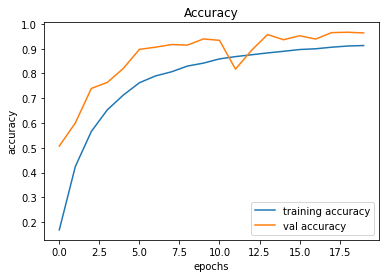

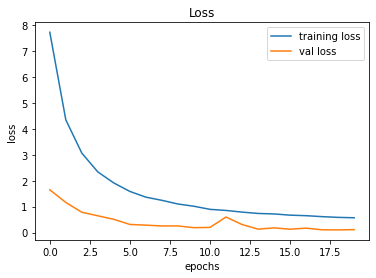

In [43]:
# plotting graphs for accuracy 

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [44]:
pred = model.predict_classes(X_test)

In [45]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(y_test, pred)*100)

Test Data accuracy:  93.10372129849564


### Hypreparameter Tuning of the model

#### class of hyperparameter model

In [25]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes,channel_dim =-1):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.channel_dim = channel_dim

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=hp.Int('conv_1_filter',
                               min_value = 32,
                               max_value = 64,
                               step = 16,
                               default =32
                              ),
                kernel_size=hp.Choice('conv_1_kernel',
                                      values = [3,5]
                                     ),
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(BatchNormalization(axis=self.channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(
            Conv2D(
                filters=hp.Int('conv_2_filter',
                               min_value = 32,
                               max_value = 128,
                               step = 32,
                               default = 64
                              ),
                activation='relu',
                kernel_size=hp.Choice('conv_2_kernel',
                                     values=[3, 5],
                                     default = 3),
                padding ='same'
            )
        )
        model.add(BatchNormalization(axis=self.channel_dim))
        model.add(
            Conv2D(
                filters=hp.Int('conv_2_a_filter',
                               min_value = 32,
                               max_value = 128,
                               step = 32,
                               default = 64
                              ),
                activation='relu',
                kernel_size=hp.Choice('conv_2_a_kernel',
                                     values=[3, 5],
                                     default = 3),
                padding ='same'
            )
        )
        model.add(BatchNormalization(axis=self.channel_dim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(
            Conv2D(
                filters=hp.Int('conv_3_filter',
                               min_value = 64,
                               max_value = 128,
                               step = 32,
                               default = 128
                              ),
                activation='relu',
                kernel_size=hp.Choice('conv_3_kernel',
                                     values=[3, 5],
                                     default = 3),
                padding ='same'
            )
        )
        model.add(BatchNormalization(axis=self.channel_dim))
        model.add(
            Conv2D(
                filters=hp.Int('conv_3_a_filter',
                               min_value = 64,
                               max_value = 128,
                               step = 32,
                               default = 128
                              ),
                activation='relu',
                kernel_size=hp.Choice('conv_3_a_kernel',
                                     values=[3, 5],
                                     default = 3),
                padding ='same'
            )
        )
        model.add(BatchNormalization(axis=self.channel_dim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(BatchNormalization())
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation= 'relu'
            )
        )
        model.add(BatchNormalization())
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [26]:
from kerastuner.tuners import RandomSearch

NUM_CLASSES = 43  # traffic sign number of classes
INPUT_SHAPE = (32, 32, 3)  # images input shape
SEED = 42
MAX_TRIALS = 5
EXECUTION_PER_TRIAL = 2

# model instantiation
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, channel_dim=-1)

# optimization algorithm `RandomSearch()`
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='traffic_sign_tuning'
)

In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 14
conv_1_filter (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_a_filter (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
conv_2_a_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_a_filter (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, '

In [28]:
N_EPOCH_SEARCH = 5

tuner.search(aug.flow(X_train, y_train), epochs=N_EPOCH_SEARCH,validation_data=(X_val, y_val))

Trial 5 Complete [00h 03m 22s]
val_accuracy: 0.8765621185302734

Best val_accuracy So Far: 0.9825299680233002
Total elapsed time: 00h 17m 04s


#### Obeseravtion : Get validation accuracy of **.9825**

In [34]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 48)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 48)        192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 64)        2

In [36]:
# Evaluate the best model.
pred = best_model.predict_classes(X_test)

In [37]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(y_test, pred)*100)

Test Data accuracy:  95.51068883610452


#### Observation : Using **optimized model** we get **test accuracy of 95.51%**

- Which is 2% better than model without hyperparameter tuning.